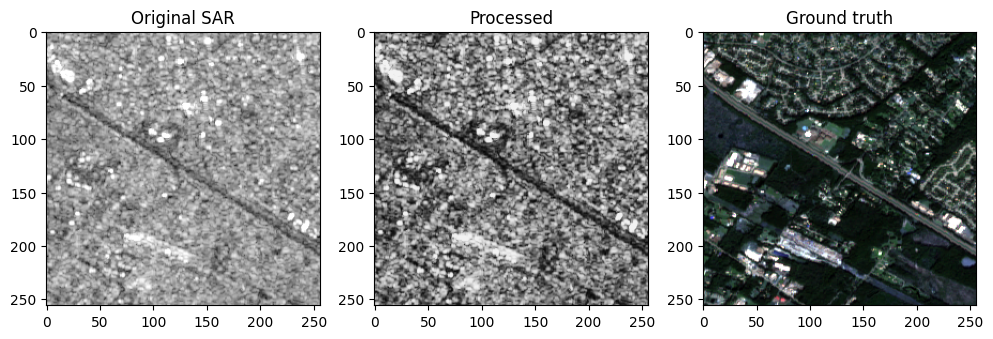

[155 139 136 111 103 104  70  89 148 172 163 169 214 236 222 214 237 224
 171 163 209 245 239 191 163 168 158 134 147 156 168 174 158 130 126 115
  93  99 119 130 127 118  96  85 100  84  58  58  65  94 149 189 193 158
 125 128 128 154 156 152 173 175 155 155 125  95  91 127 148 127  96 110
 107  99  93  80 100 123 129 137 140 146 142 142 145 157 109 114 152 162
 159 153 159 163 155 148 139 129 118 140 154 137 126 138 138 127 130 128
 121 130 142 142 121 114 148 168 174 179 183 170 133 129 156 166 165 180
 186 151 121 137 150 142 133 133 122 195 215 223 227 223 232 240 219 169
 138 138 129 150 151 136 129 133 129 112 132 162 164 155 150 149 149 135
 151 154 122 132 118  93 120 124 113 101 167 202 188 168 165 156 156 145
 118  91  94  90 109 130 124 106 101  93  91  98  95 102 102 118 149 161
 155 179 208 217 205 180 177 183 172 147 141 100  38 109 114 120 130 118
 149 178 174 147 121 138 161 169 152 130 152 173 176 158 115 144 184 213
 213 183 131 117 153 153 138 145 123  88  57 152 17

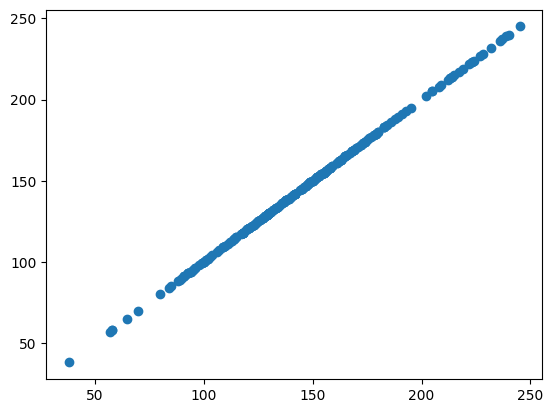

In [ ]:
import numpy as np
import cv2
from scipy import ndimage
from skimage.restoration import denoise_nl_means, estimate_sigma

def convert_log_to_8bit(log_image, percentile_min=2, percentile_max=98):
    """
    Преобразование логарифмированного SAR-изображения в 8-битный диапазон (0-255)
    с использованием перцентилей для отсечения выбросов.
    
    Параметры:
    log_image: логарифмированное SAR-изображение
    percentile_min: нижний перцентиль для отсечения (по умолчанию 2%)
    percentile_max: верхний перцентиль для отсечения (по умолчанию 98%)
    """
    # Отсекаем выбросы с помощью перцентилей
    p_low, p_high = np.percentile(log_image, (percentile_min, percentile_max))
    
    # Обрезаем значения за пределами перцентилей
    clipped = np.clip(log_image, p_low, p_high)
    
    # Линейно масштабируем обрезанные значения в диапазон 0-255
    scaled = ((clipped - p_low) / (p_high - p_low))
    
    return scaled

def sar_preprocessing(
    image: np.ndarray,
    log_scale: bool = True,
    filtering: bool = True,
    normalization: bool = True,
    scale: bool = True,
    dataset_mean: float = None,
    dataset_std: float = None
) -> np.ndarray:
    """
    Предобработка SAR изображения.
    
    Параметры:
    image: входное SAR изображение (1 канал)
    log_scale: преобразование в dB
    filtering: применение фильтра Ли
    normalization: нормализация
    dataset_mean: среднее по датасету (если None - вычисляется по изображению)
    dataset_std: std по датасету (если None - вычисляется по изображению)
    """
    processed = image.copy().astype(np.float32)
    
    # 1. Логарифмическое преобразование
    if log_scale:
        processed = 10 * np.log10(processed + 1e-7)  # Добавляем маленькое значение чтобы избежать log(0)
    
    # 2. Фильтрация (фильтр Ли)
    if filtering:
        processed = lee_filter(processed, window_size=5)
    
    # 3. Нормализация
    if normalization:
        if dataset_mean is not None and dataset_std is not None:
            processed = (processed - dataset_mean) / dataset_std
        else:
            processed = (processed - np.mean(processed)) / np.std(processed)
    
    if scale:
        processed = convert_log_to_8bit(processed)
    return processed

def lee_filter(image: np.ndarray, window_size: int = 5) -> np.ndarray:
    """
    Реализация фильтра Ли для подавления speckle-шума.
    """
    # Создание окрестности для каждого пикселя
    pad = window_size // 2
    image_padded = np.pad(image, pad, mode='reflect')
    
    result = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            window = image_padded[i:i+window_size, j:j+window_size]
            mean = np.mean(window)
            std = np.std(window)
            
            # Коэффициент фильтрации
            if std == 0:
                k = 0
            else:
                k = (1 - (mean * std**2) / (mean**2 * (std**2 + 1)))
            
            result[i, j] = mean + k * (image[i, j] - mean)
    
    return result

def zscore_sigmoid_normalization(log_image):
    """
    Z-score нормализация с последующим сигмоидным преобразованием в [0, 1]
    """
    # Z-score нормализация
    mean = np.mean(log_image)
    std = np.std(log_image)
    z_normalized = (log_image - mean) / std
    
    # Сигмоидное преобразование в диапазон [0, 1]
    sigmoid = 1 / (1 + np.exp(-z_normalized))
    
    return sigmoid.astype(np.float32)

# Пример использования
if __name__ == "__main__":
    # Загрузка SAR изображения (замените на свой способ загрузки)
    sar_image = cv2.imread('../sen12-data/v_2/urban/s1/ROIs1970_fall_s1_8_p1.png')
    opt_image = cv2.imread('../sen12-data/v_2/urban/s2/ROIs1970_fall_s2_8_p1.png')
    
    # Предобработка
    processed_image = sar_preprocessing(
        sar_image,
        log_scale=True,
        filtering=False,
        normalization=True,
        scale=True,
        dataset_mean=None,  # Замените на предварительно вычисленные значения
        dataset_std=None    # если работаете с целым датасетом
    )
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    plt.subplot(131)
    plt.title("Original SAR")
    plt.imshow(sar_image, cmap='gray')
    plt.subplot(132)
    plt.title("Processed")
    plt.imshow(zscore_sigmoid_normalization(sar_image), cmap='gray')
    plt.subplot(133)
    plt.title("Ground truth")
    plt.imshow(opt_image, cmap='gray')
    plt.show()

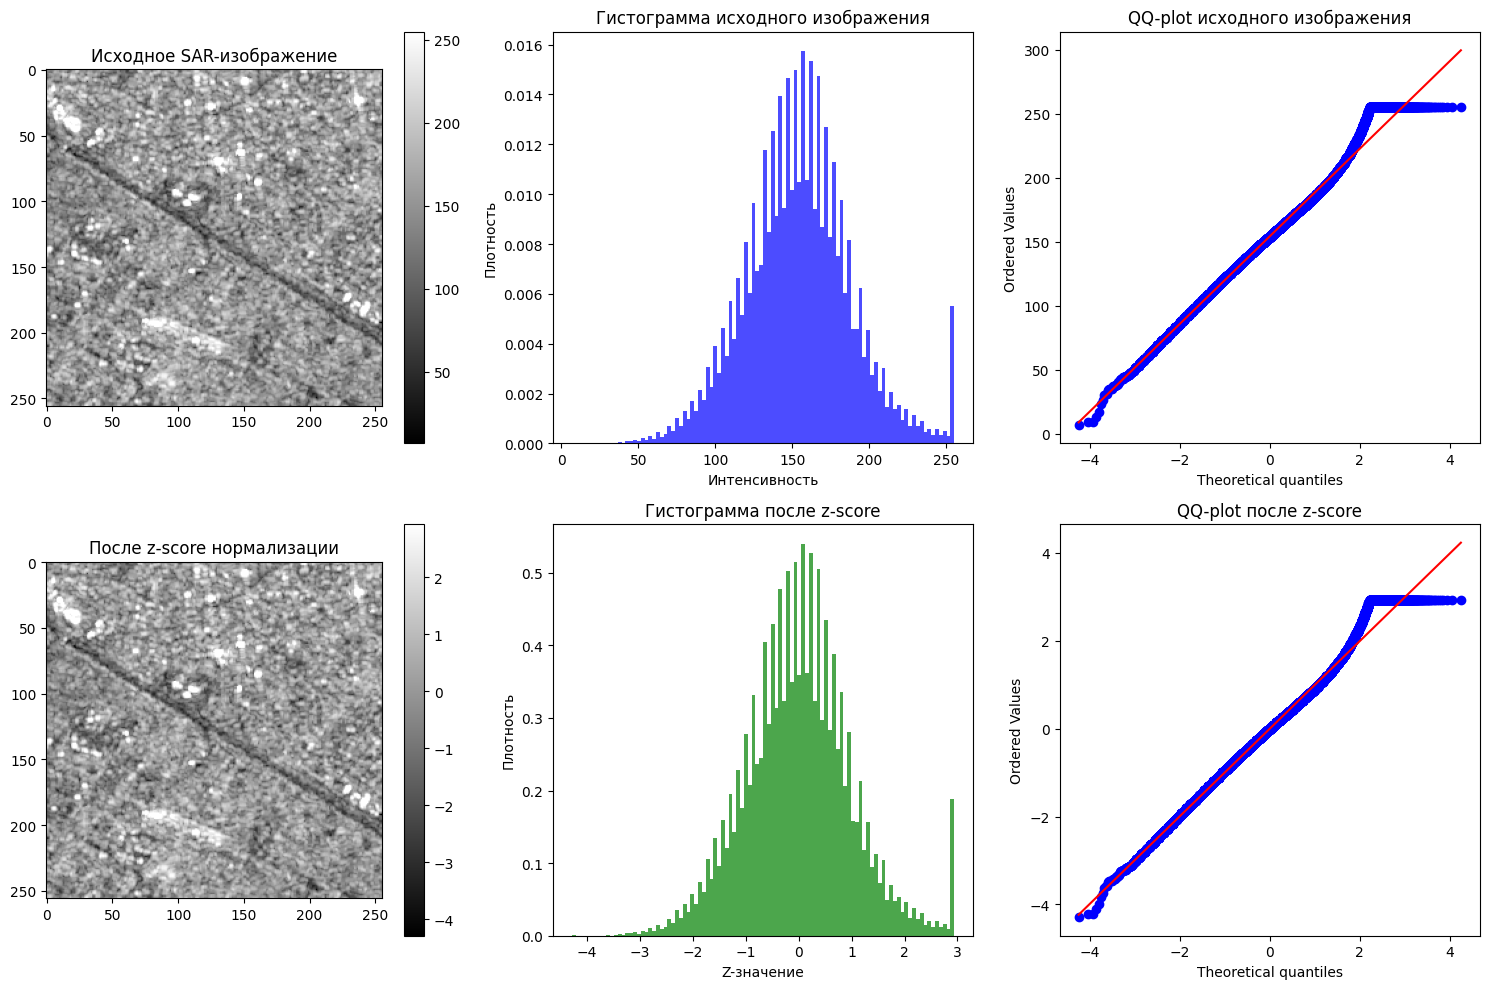

=== СТАТИСТИКИ ИСХОДНОГО ИЗОБРАЖЕНИЯ ===
Минимум: 7.00
Максимум: 255.00
Среднее: 154.15
Стандартное отклонение: 34.33
Асимметрия: 0.21
Эксцесс: 0.56

=== СТАТИСТИКИ ПОСЛЕ Z-SCORE НОРМАЛИЗАЦИИ ===
Минимум: -4.29
Максимум: 2.94
Среднее: -0.00
Стандартное отклонение: 1.00
Асимметрия: 0.21
Эксцесс: 0.56


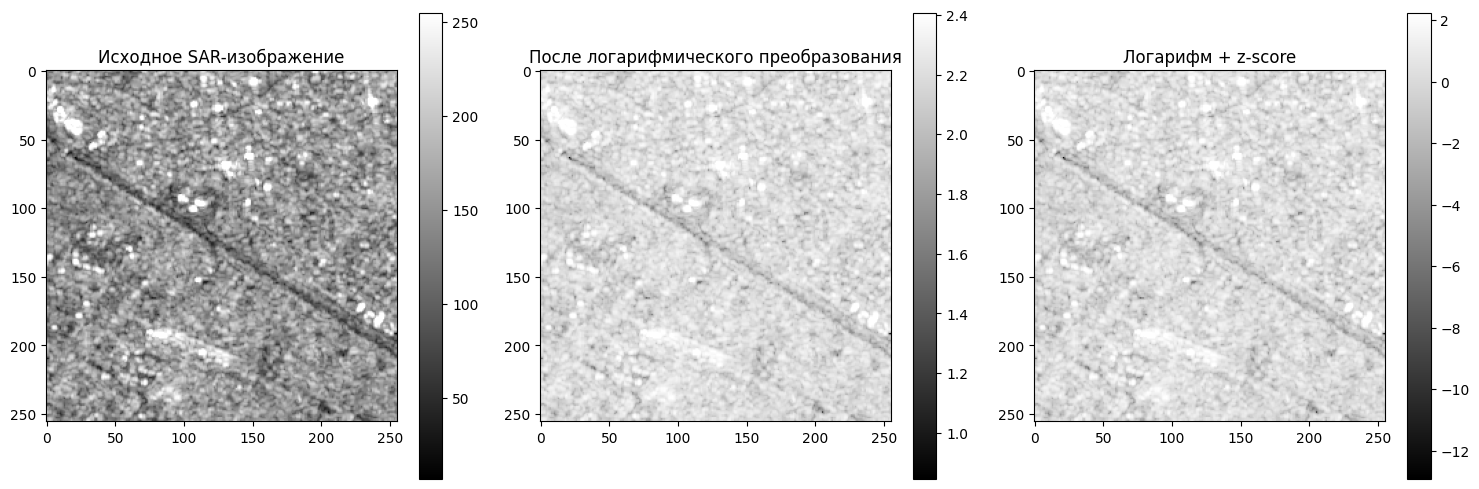

=== СТАТИСТИКИ ПОСЛЕ ЛОГАРИФМИЧЕСКОГО ПРЕОБРАЗОВАНИЯ ===
Минимум: 0.85
Максимум: 2.41
Среднее: 2.18
Стандартное отклонение: 0.10

=== СТАТИСТИКИ ПОСЛЕ ЛОГАРИФМА И Z-SCORE ===
Минимум: -12.93
Максимум: 2.23
Среднее: 0.00
Стандартное отклонение: 1.00


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import stats

def load_and_analyze_sar(image_path):
    """
    Загрузка и анализ SAR-изображения
    """
    # Загрузка изображения (предполагается, что это одноканальное SAR-изображение)
    sar_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if sar_image is None:
        raise ValueError(f"Не удалось загрузить изображение: {image_path}")
    
    # Преобразование в float32 для точных вычислений
    sar_image = sar_image.astype(np.float32)
    
    # Визуализация исходного изображения
    plt.figure(figsize=(15, 10))
    
    # Исходное изображение
    plt.subplot(2, 3, 1)
    plt.imshow(sar_image, cmap='gray')
    plt.title('Исходное SAR-изображение')
    plt.colorbar()
    
    # Гистограмма исходного изображения
    plt.subplot(2, 3, 2)
    plt.hist(sar_image.flatten(), bins=100, density=True, alpha=0.7, color='blue')
    plt.title('Гистограмма исходного изображения')
    plt.xlabel('Интенсивность')
    plt.ylabel('Плотность')
    
    # QQ-plot исходного изображения
    plt.subplot(2, 3, 3)
    stats.probplot(sar_image.flatten(), dist="norm", plot=plt)
    plt.title('QQ-plot исходного изображения')
    
    # Z-score нормализация
    mean_val = np.mean(sar_image)
    std_val = np.std(sar_image)
    zscore_image = (sar_image - mean_val) / std_val
    
    # Визуализация после z-score нормализации
    plt.subplot(2, 3, 4)
    plt.imshow(zscore_image, cmap='gray')
    plt.title('После z-score нормализации')
    plt.colorbar()
    
    # Гистограмма после z-score нормализации
    plt.subplot(2, 3, 5)
    plt.hist(zscore_image.flatten(), bins=100, density=True, alpha=0.7, color='green')
    plt.title('Гистограмма после z-score')
    plt.xlabel('Z-значение')
    plt.ylabel('Плотность')
    
    # QQ-plot после z-score нормализации
    plt.subplot(2, 3, 6)
    stats.probplot(zscore_image.flatten(), dist="norm", plot=plt)
    plt.title('QQ-plot после z-score')
    
    plt.tight_layout()
    plt.show()
    
    # Вывод статистик
    print("=== СТАТИСТИКИ ИСХОДНОГО ИЗОБРАЖЕНИЯ ===")
    print(f"Минимум: {np.min(sar_image):.2f}")
    print(f"Максимум: {np.max(sar_image):.2f}")
    print(f"Среднее: {mean_val:.2f}")
    print(f"Стандартное отклонение: {std_val:.2f}")
    print(f"Асимметрия: {stats.skew(sar_image.flatten()):.2f}")
    print(f"Эксцесс: {stats.kurtosis(sar_image.flatten()):.2f}")
    
    print("\n=== СТАТИСТИКИ ПОСЛЕ Z-SCORE НОРМАЛИЗАЦИИ ===")
    print(f"Минимум: {np.min(zscore_image):.2f}")
    print(f"Максимум: {np.max(zscore_image):.2f}")
    print(f"Среднее: {np.mean(zscore_image):.2f}")
    print(f"Стандартное отклонение: {np.std(zscore_image):.2f}")
    print(f"Асимметрия: {stats.skew(zscore_image.flatten()):.2f}")
    print(f"Эксцесс: {stats.kurtosis(zscore_image.flatten()):.2f}")
    
    return sar_image, zscore_image

# Дополнительная функция для анализа с логарифмическим преобразованием
def analyze_with_log_transform(image_path):
    """
    Анализ с предварительным логарифмическим преобразованием
    """
    # Загрузка изображения
    sar_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    
    # Логарифмическое преобразование
    log_image = np.log10(sar_image + 1e-7)  # Добавляем маленькое значение чтобы избежать log(0)
    
    # Визуализация
    plt.figure(figsize=(15, 5))
    
    # Исходное изображение
    plt.subplot(1, 3, 1)
    plt.imshow(sar_image, cmap='gray')
    plt.title('Исходное SAR-изображение')
    plt.colorbar()
    
    # После логарифмического преобразования
    plt.subplot(1, 3, 2)
    plt.imshow(log_image, cmap='gray')
    plt.title('После логарифмического преобразования')
    plt.colorbar()
    
    # После z-score нормализации логарифмированного изображения
    log_zscore = (log_image - np.mean(log_image)) / np.std(log_image)
    plt.subplot(1, 3, 3)
    plt.imshow(log_zscore, cmap='gray')
    plt.title('Логарифм + z-score')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
    # Вывод статистик
    print("=== СТАТИСТИКИ ПОСЛЕ ЛОГАРИФМИЧЕСКОГО ПРЕОБРАЗОВАНИЯ ===")
    print(f"Минимум: {np.min(log_image):.2f}")
    print(f"Максимум: {np.max(log_image):.2f}")
    print(f"Среднее: {np.mean(log_image):.2f}")
    print(f"Стандартное отклонение: {np.std(log_image):.2f}")
    
    print("\n=== СТАТИСТИКИ ПОСЛЕ ЛОГАРИФМА И Z-SCORE ===")
    print(f"Минимум: {np.min(log_zscore):.2f}")
    print(f"Максимум: {np.max(log_zscore):.2f}")
    print(f"Среднее: {np.mean(log_zscore):.2f}")
    print(f"Стандартное отклонение: {np.std(log_zscore):.2f}")

# Использование
if __name__ == "__main__":
    # Замените 'your_sar_image.tif' на путь к вашему SAR-изображению
    image_path = '../sen12-data/v_2/urban/s1/ROIs1970_fall_s1_8_p1.png'
    
    try:
        # Анализ без логарифмического преобразования
        original, normalized = load_and_analyze_sar(image_path)
        
        # Анализ с логарифмическим преобразованием
        analyze_with_log_transform(image_path)
        
    except Exception as e:
        print(f"Ошибка: {e}")
        print("Создаем тестовое SAR-изображение для демонстрации...")
        
        # Создаем синтетическое SAR-изображение для демонстрации
        np.random.seed(42)
        # Имитируем speckle-шум (мультипликативный)
        speckle = np.random.gamma(1, 1, (256, 256))
        # Создаем структуру изображения
        x, y = np.meshgrid(np.linspace(-2, 2, 256), np.linspace(-2, 2, 256))
        structure = np.exp(-(x**2 + y**2))
        # Комбинируем
        synthetic_sar = structure * speckle * 1000
        
        # Сохраняем и анализируем
        cv2.imwrite('synthetic_sar.tif', synthetic_sar)
        original, normalized = load_and_analyze_sar('synthetic_sar.tif')
        analyze_with_log_transform('synthetic_sar.tif')

=== Z-SCORE НОРМАЛИЗАЦИЯ ===


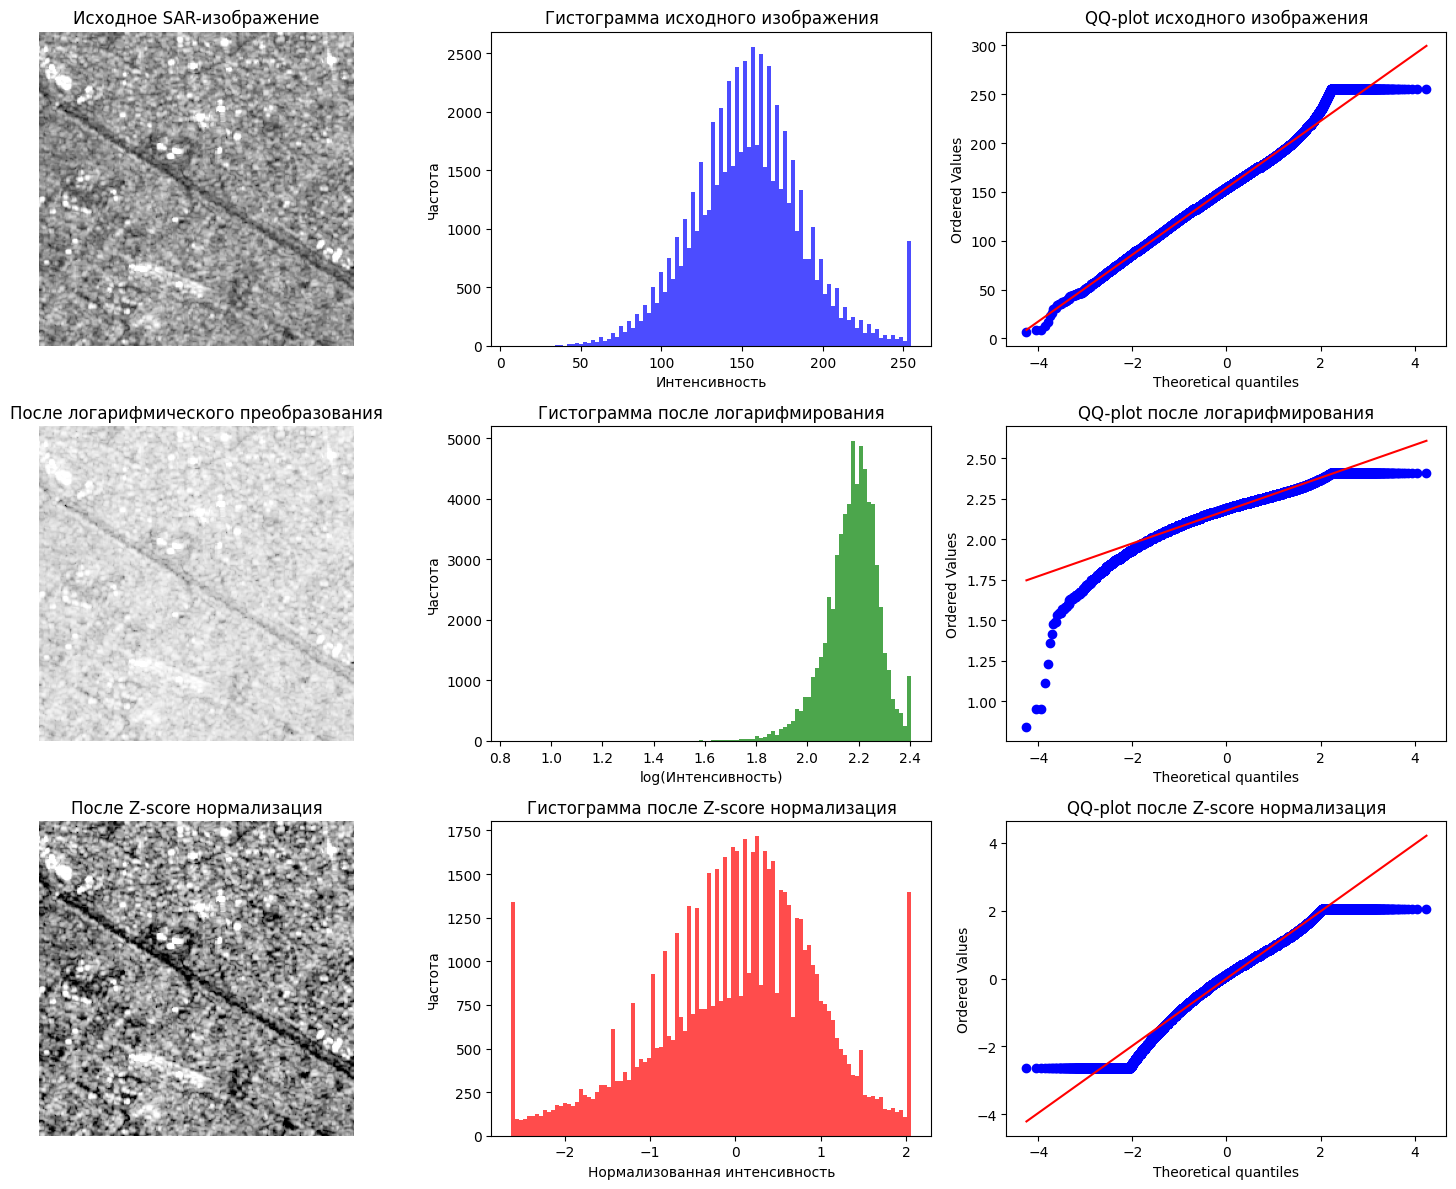

=== СТАТИСТИКИ ПРЕДОБРАБОТКИ ===
Метод нормализации: Z-score нормализация
Диапазон перцентилей: 2%-98%

Исходное изображение:
  Минимум: 7.00, Максимум: 255.00
  Среднее: 154.15, Стандартное отклонение: 34.33

После логарифмирования:
  Минимум: 0.85, Максимум: 2.41
  Среднее: 2.18, Стандартное отклонение: 0.10

После отсечения выбросов:
  Минимум: 1.92, Максимум: 2.38
  Среднее: 2.18, Стандартное отклонение: 0.10

После Z-score нормализация:
  Минимум: -2.63, Максимум: 2.06
  Среднее: -0.00, Стандартное отклонение: 1.00

=== MIN-MAX НОРМАЛИЗАЦИЯ ===


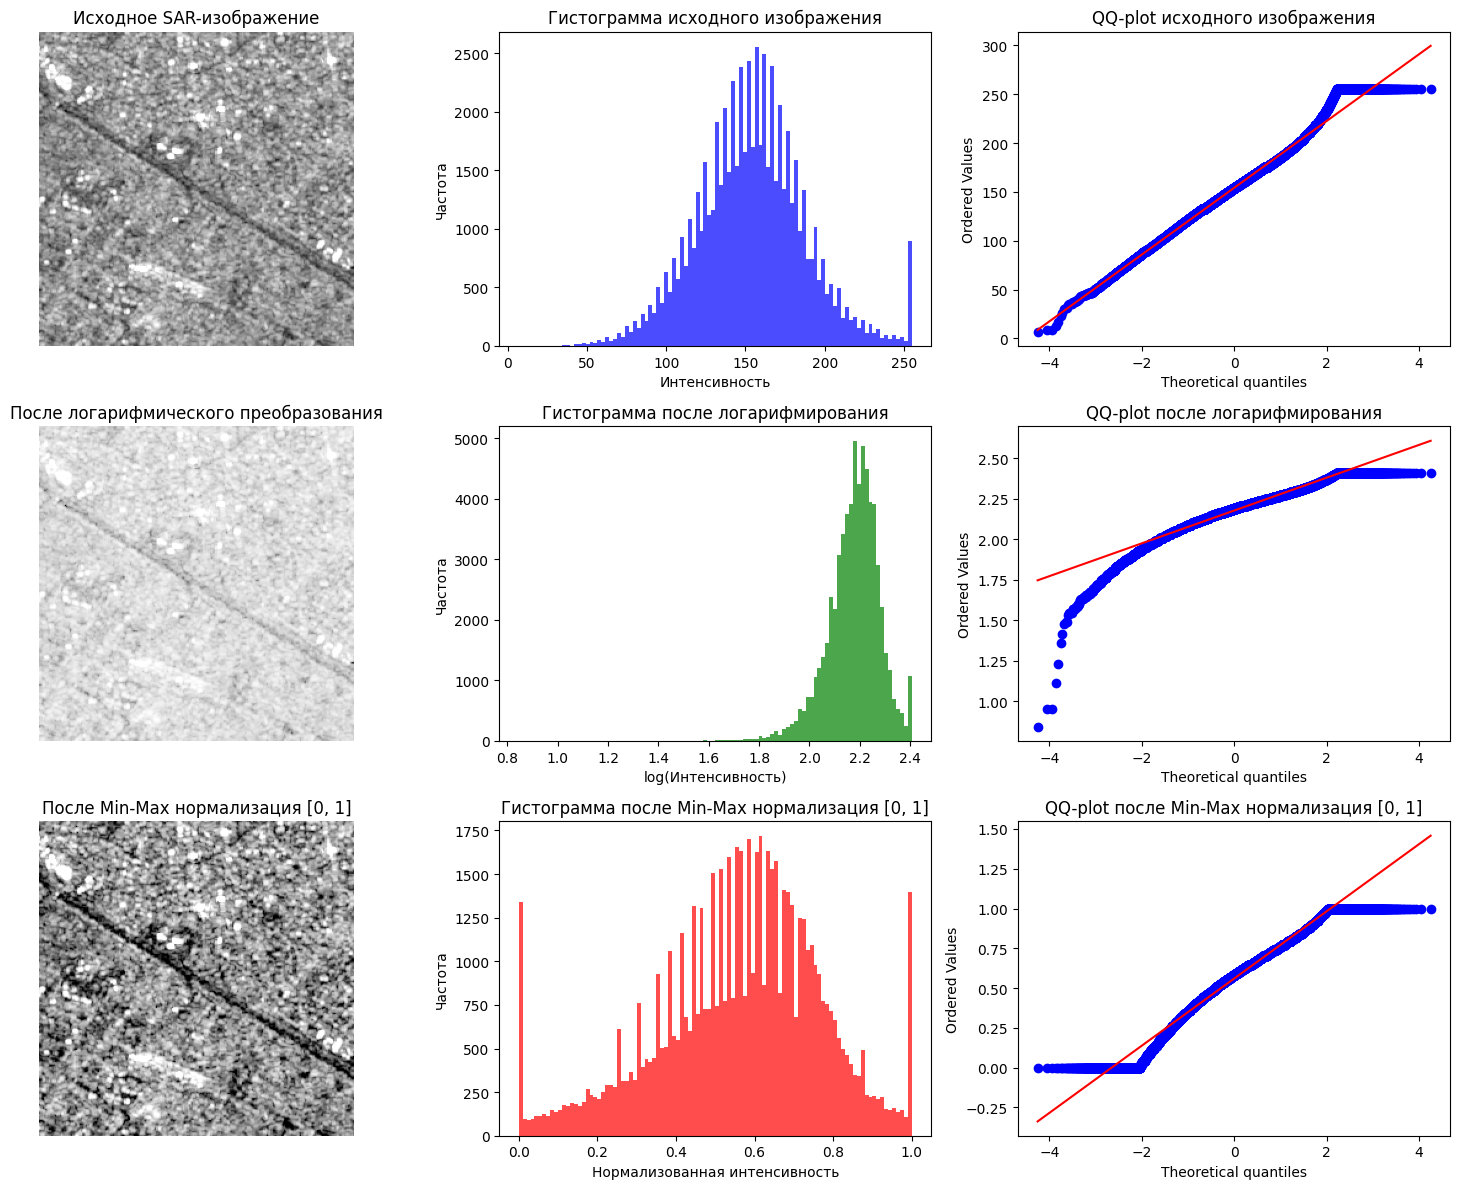

=== СТАТИСТИКИ ПРЕДОБРАБОТКИ ===
Метод нормализации: Min-Max нормализация [0, 1]
Диапазон перцентилей: 2%-98%

Исходное изображение:
  Минимум: 7.00, Максимум: 255.00
  Среднее: 154.15, Стандартное отклонение: 34.33

После логарифмирования:
  Минимум: 0.85, Максимум: 2.41
  Среднее: 2.18, Стандартное отклонение: 0.10

После отсечения выбросов:
  Минимум: 1.92, Максимум: 2.38
  Среднее: 2.18, Стандартное отклонение: 0.10

После Min-Max нормализация [0, 1]:
  Минимум: 0.00, Максимум: 1.00
  Среднее: 0.56, Стандартное отклонение: 0.21

=== СРАВНЕНИЕ МЕТОДОВ ===


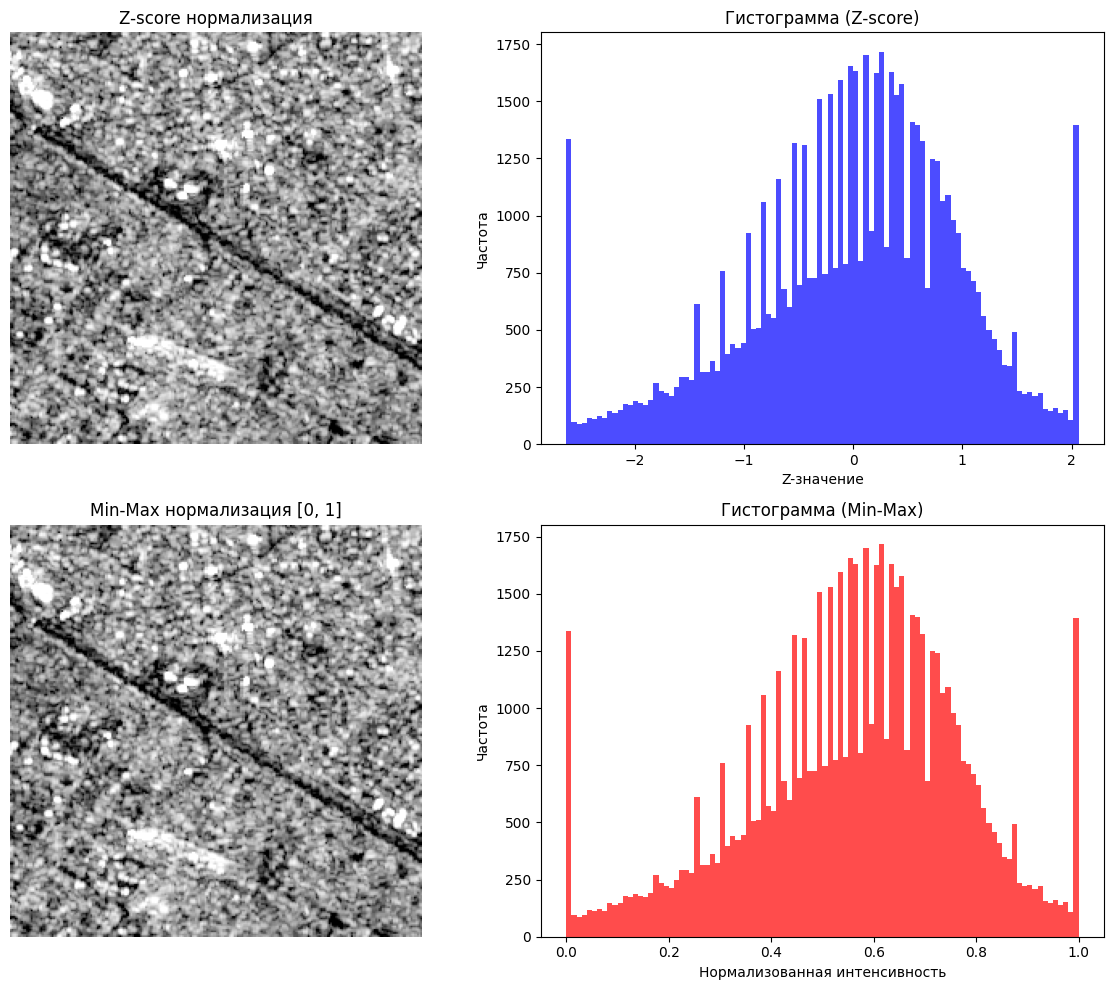

=== СРАВНЕНИЕ МЕТОДОВ НОРМАЛИЗАЦИИ ===
Z-score нормализация:
  Диапазон: [-2.63, 2.06]
  Среднее: -0.00, STD: 1.00

Min-Max нормализация [0, 1]:
  Диапазон: [0.00, 1.00]
  Среднее: 0.56, STD: 0.21

=== РЕКОМЕНДАЦИИ ===
Z-score нормализация лучше подходит для:
- Алгоритмов, чувствительных к распределению данных (например, SVM, K-mean)
- Когда важны относительные различия в интенсивности
- Когда данные имеют примерно нормальное распределение после преобразований

Min-Max нормализация лучше подходит для:
- Нейронных сетей с активационными функциями типа сигмоиды
- Когда нужно гарантировать определенный диапазон значений
- Для визуализации и интерпретации результатов


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import stats

def sar_preprocessing_pipeline(sar_image, method='zscore', percentile_range=(2, 98)):
    """
    Пайплайн предобработки SAR-изображений для машинного обучения
    
    Параметры:
    sar_image: входное SAR-изображение
    method: метод нормализации ('zscore' или 'minmax')
    percentile_range: диапазон перцентилей для отсечения выбросов
    """
    # 1. Логарифмическое преобразование
    log_image = np.log10(sar_image.astype(np.float32) + 1e-7)
    
    # 2. Отсечение выбросов с помощью перцентилей
    p_low, p_high = np.percentile(log_image, percentile_range)
    clipped_image = np.clip(log_image, p_low, p_high)
    
    # 3. Применение выбранного метода нормализации
    if method == 'zscore':
        # Z-score нормализация
        mean_val = np.mean(clipped_image)
        std_val = np.std(clipped_image)
        normalized_image = (clipped_image - mean_val) / std_val
        normalization_type = 'Z-score нормализация'
        
    elif method == 'minmax':
        # Min-Max нормализация в диапазон [0, 1]
        normalized_image = (clipped_image - p_low) / (p_high - p_low)
        normalization_type = 'Min-Max нормализация [0, 1]'
    
    return log_image, clipped_image, normalized_image, normalization_type

def visualize_sar_preprocessing(sar_image, method='zscore', percentile_range=(2, 98)):
    """
    Визуализация процесса предобработки SAR-изображения
    """
    # Выполняем предобработку
    log_image, clipped_image, normalized_image, norm_type = sar_preprocessing_pipeline(
        sar_image, method, percentile_range
    )
    
    # Создаем фигуру с несколькими subplots
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    
    # 1. Исходное изображение
    axes[0, 0].imshow(sar_image, cmap='gray')
    axes[0, 0].set_title('Исходное SAR-изображение')
    axes[0, 0].axis('off')
    
    # 2. Гистограмма исходного изображения
    axes[0, 1].hist(sar_image.flatten(), bins=100, color='blue', alpha=0.7)
    axes[0, 1].set_title('Гистограмма исходного изображения')
    axes[0, 1].set_xlabel('Интенсивность')
    axes[0, 1].set_ylabel('Частота')
    
    # 3. QQ-plot исходного изображения
    stats.probplot(sar_image.flatten(), dist="norm", plot=axes[0, 2])
    axes[0, 2].set_title('QQ-plot исходного изображения')
    
    # 4. Логарифмированное изображение
    axes[1, 0].imshow(log_image, cmap='gray')
    axes[1, 0].set_title('После логарифмического преобразования')
    axes[1, 0].axis('off')
    
    # 5. Гистограмма логарифмированного изображения
    axes[1, 1].hist(log_image.flatten(), bins=100, color='green', alpha=0.7)
    axes[1, 1].set_title('Гистограмма после логарифмирования')
    axes[1, 1].set_xlabel('log(Интенсивность)')
    axes[1, 1].set_ylabel('Частота')
    
    # 6. QQ-plot логарифмированного изображения
    stats.probplot(log_image.flatten(), dist="norm", plot=axes[1, 2])
    axes[1, 2].set_title('QQ-plot после логарифмирования')
    
    # 7. Нормализованное изображение
    axes[2, 0].imshow(normalized_image, cmap='gray')
    axes[2, 0].set_title(f'После {norm_type}')
    axes[2, 0].axis('off')
    
    # 8. Гистограмма нормализованного изображения
    axes[2, 1].hist(normalized_image.flatten(), bins=100, color='red', alpha=0.7)
    axes[2, 1].set_title(f'Гистограмма после {norm_type}')
    axes[2, 1].set_xlabel('Нормализованная интенсивность')
    axes[2, 1].set_ylabel('Частота')
    
    # 9. QQ-plot нормализованного изображения
    stats.probplot(normalized_image.flatten(), dist="norm", plot=axes[2, 2])
    axes[2, 2].set_title(f'QQ-plot после {norm_type}')
    
    plt.tight_layout()
    plt.show()
    
    # Вывод статистик
    print("=== СТАТИСТИКИ ПРЕДОБРАБОТКИ ===")
    print(f"Метод нормализации: {norm_type}")
    print(f"Диапазон перцентилей: {percentile_range[0]}%-{percentile_range[1]}%")
    print("\nИсходное изображение:")
    print(f"  Минимум: {np.min(sar_image):.2f}, Максимум: {np.max(sar_image):.2f}")
    print(f"  Среднее: {np.mean(sar_image):.2f}, Стандартное отклонение: {np.std(sar_image):.2f}")
    
    print("\nПосле логарифмирования:")
    print(f"  Минимум: {np.min(log_image):.2f}, Максимум: {np.max(log_image):.2f}")
    print(f"  Среднее: {np.mean(log_image):.2f}, Стандартное отклонение: {np.std(log_image):.2f}")
    
    print("\nПосле отсечения выбросов:")
    print(f"  Минимум: {np.min(clipped_image):.2f}, Максимум: {np.max(clipped_image):.2f}")
    print(f"  Среднее: {np.mean(clipped_image):.2f}, Стандартное отклонение: {np.std(clipped_image):.2f}")
    
    print(f"\nПосле {norm_type}:")
    print(f"  Минимум: {np.min(normalized_image):.2f}, Максимум: {np.max(normalized_image):.2f}")
    print(f"  Среднее: {np.mean(normalized_image):.2f}, Стандартное отклонение: {np.std(normalized_image):.2f}")
    
    return normalized_image

def compare_normalization_methods(sar_image, percentile_range=(2, 98)):
    """
    Сравнение двух методов нормализации
    """
    # Применяем оба метода
    _, _, zscore_norm, _ = sar_preprocessing_pipeline(sar_image, 'zscore', percentile_range)
    _, _, minmax_norm, _ = sar_preprocessing_pipeline(sar_image, 'minmax', percentile_range)
    
    # Визуализация сравнения
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Z-score нормализация
    axes[0, 0].imshow(zscore_norm, cmap='gray')
    axes[0, 0].set_title('Z-score нормализация')
    axes[0, 0].axis('off')
    
    axes[0, 1].hist(zscore_norm.flatten(), bins=100, color='blue', alpha=0.7)
    axes[0, 1].set_title('Гистограмма (Z-score)')
    axes[0, 1].set_xlabel('Z-значение')
    axes[0, 1].set_ylabel('Частота')
    
    # Min-Max нормализация
    axes[1, 0].imshow(minmax_norm, cmap='gray')
    axes[1, 0].set_title('Min-Max нормализация [0, 1]')
    axes[1, 0].axis('off')
    
    axes[1, 1].hist(minmax_norm.flatten(), bins=100, color='red', alpha=0.7)
    axes[1, 1].set_title('Гистограмма (Min-Max)')
    axes[1, 1].set_xlabel('Нормализованная интенсивность')
    axes[1, 1].set_ylabel('Частота')
    
    plt.tight_layout()
    plt.show()
    
    # Вывод статистик для сравнения
    print("=== СРАВНЕНИЕ МЕТОДОВ НОРМАЛИЗАЦИИ ===")
    print("Z-score нормализация:")
    print(f"  Диапазон: [{np.min(zscore_norm):.2f}, {np.max(zscore_norm):.2f}]")
    print(f"  Среднее: {np.mean(zscore_norm):.2f}, STD: {np.std(zscore_norm):.2f}")
    
    print("\nMin-Max нормализация [0, 1]:")
    print(f"  Диапазон: [{np.min(minmax_norm):.2f}, {np.max(minmax_norm):.2f}]")
    print(f"  Среднее: {np.mean(minmax_norm):.2f}, STD: {np.std(minmax_norm):.2f}")
    
    return zscore_norm, minmax_norm

# Основная функция
if __name__ == "__main__":
    # Загрузка SAR-изображения (замените на свой путь)
    image_path = '../sen12-data/v_2/urban/s1/ROIs1970_fall_s1_8_p1.png'
    
    try:
        # Пытаемся загрузить изображение
        sar_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if sar_image is None:
            raise ValueError("Не удалось загрузить изображение")
    except:
        # Создаем синтетическое SAR-изображение для демонстрации
        print("Создаем синтетическое SAR-изображение для демонстрации...")
        np.random.seed(42)
        x, y = np.meshgrid(np.linspace(-2, 2, 256), np.linspace(-2, 2, 256))
        structure = np.exp(-(x**2 + y**2))
        speckle = np.random.gamma(1, 1, (256, 256))
        sar_image = (structure * speckle * 1000).astype(np.uint8)
    
    # Визуализация предобработки с Z-score нормализацией
    print("=== Z-SCORE НОРМАЛИЗАЦИЯ ===")
    zscore_result = visualize_sar_preprocessing(sar_image, method='zscore')
    
    # Визуализация предобработки с Min-Max нормализацией
    print("\n=== MIN-MAX НОРМАЛИЗАЦИЯ ===")
    minmax_result = visualize_sar_preprocessing(sar_image, method='minmax')
    
    # Сравнение обоих методов
    print("\n=== СРАВНЕНИЕ МЕТОДОВ ===")
    zscore_norm, minmax_norm = compare_normalization_methods(sar_image)
    
    # Дополнительная информация для выбора метода
    print("\n=== РЕКОМЕНДАЦИИ ===")
    print("Z-score нормализация лучше подходит для:")
    print("- Алгоритмов, чувствительных к распределению данных (например, SVM, K-mean)")
    print("- Когда важны относительные различия в интенсивности")
    print("- Когда данные имеют примерно нормальное распределение после преобразований")
    
    print("\nMin-Max нормализация лучше подходит для:")
    print("- Нейронных сетей с активационными функциями типа сигмоиды")
    print("- Когда нужно гарантировать определенный диапазон значений")
    print("- Для визуализации и интерпретации результатов")